In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 15.65 MiB/s, done.
Updating files: 100% (12939/12939), done.


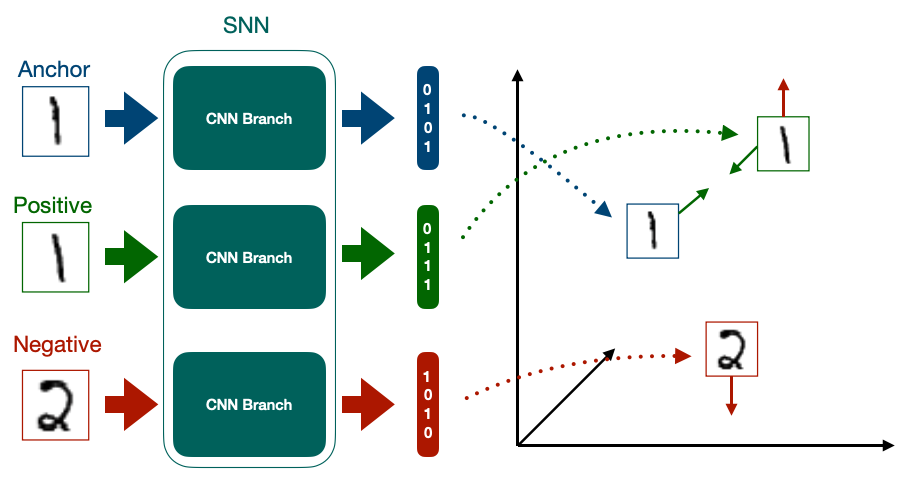

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [12]:
DATA_DIR = "/content/Person-Re-Id-Dataset/train/"
CSV_FILE = "/content/Person-Re-Id-Dataset/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS  =25

DEVICE = "cuda"

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [18]:
row = df.iloc[10]
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)


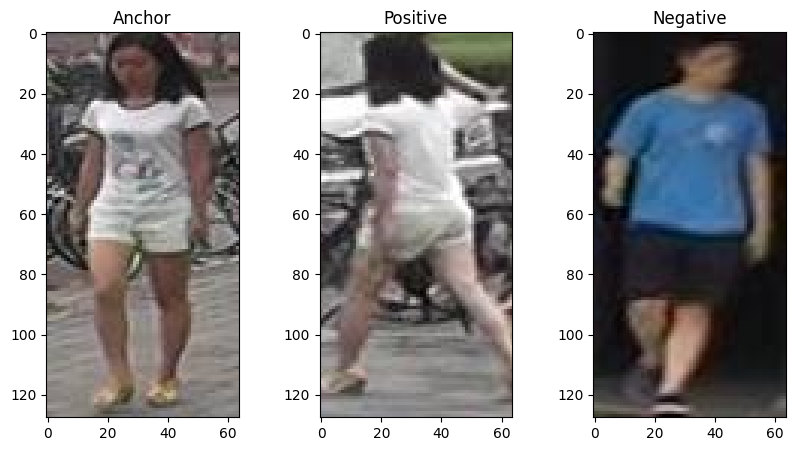

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [20]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Create APN Dataset

In [21]:
class APN_Dataset(Dataset):
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    # convert image to torch tensor
    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img

In [22]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 3200
Size of validset: 800


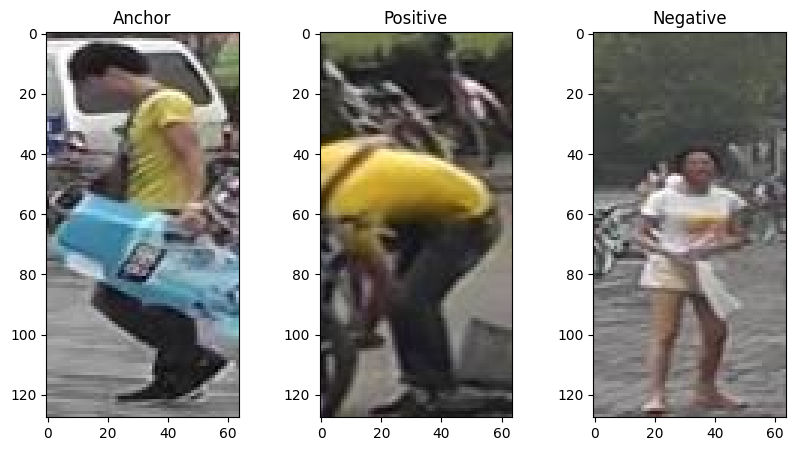

In [23]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [25]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

In [26]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [27]:
for A, P, N in trainloader:
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [30]:
class APN_Model(nn.Module):
  def __init__(self, emb_size=512):
    super(APN_Model, self).__init__()
    self.efficientnet = timm.create_model("efficientnet_b0", pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [ ]:
model = APN_Model()
model.to(DEVICE)

# Create Train and Eval function

In [32]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train() # ON droput
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)

In [33]:
def eval_fn(model, dataloader, criterion):
  model.eval() # OFF droput
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()
    return total_loss / len(dataloader)

In [34]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [35]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    best_valid_loss = valid_loss
    print("SAVED WEIGHTS SUCCESS")

  print(f"EPOCHS: {i+1} train_loss: {train_loss} valid_loss: {valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  7.92it/s]


SAVED WEIGHTS SUCCESS
EPOCHS: 1 train_loss: 0.6218855178356171 valid_loss: 0.5567315924167633


100%|██████████| 25/25 [00:02<00:00, 10.82it/s]


SAVED WEIGHTS SUCCESS
EPOCHS: 2 train_loss: 0.3302211672067642 valid_loss: 0.2597511738538742


100%|██████████| 25/25 [00:02<00:00, 11.00it/s]


SAVED WEIGHTS SUCCESS
EPOCHS: 3 train_loss: 0.15016228809952736 valid_loss: 0.19589101314544677


100%|██████████| 25/25 [00:02<00:00, 11.02it/s]


EPOCHS: 4 train_loss: 0.09948300711810588 valid_loss: 0.23066965699195863


100%|██████████| 25/25 [00:02<00:00, 10.90it/s]


EPOCHS: 5 train_loss: 0.08438311725854873 valid_loss: 0.24699064016342162


100%|██████████| 25/25 [00:02<00:00,  8.39it/s]


EPOCHS: 6 train_loss: 0.08095142714679242 valid_loss: 0.22314131140708923


100%|██████████| 25/25 [00:02<00:00, 11.10it/s]


EPOCHS: 7 train_loss: 0.07883304938673973 valid_loss: 0.19745670080184938


100%|██████████| 25/25 [00:02<00:00, 10.92it/s]


SAVED WEIGHTS SUCCESS
EPOCHS: 8 train_loss: 0.06304052889347077 valid_loss: 0.17230943024158477


100%|██████████| 25/25 [00:02<00:00,  9.29it/s]


SAVED WEIGHTS SUCCESS
EPOCHS: 9 train_loss: 0.07527861654758454 valid_loss: 0.169386345744133


100%|██████████| 25/25 [00:02<00:00, 10.59it/s]


SAVED WEIGHTS SUCCESS
EPOCHS: 10 train_loss: 0.03875667378306389 valid_loss: 0.11751736283302307


100%|██████████| 25/25 [00:02<00:00, 10.38it/s]


EPOCHS: 11 train_loss: 0.013897726982831956 valid_loss: 0.11824898660182953


100%|██████████| 25/25 [00:02<00:00, 10.70it/s]


EPOCHS: 12 train_loss: 0.03108318701386452 valid_loss: 0.134236261844635


100%|██████████| 25/25 [00:02<00:00, 10.89it/s]


EPOCHS: 13 train_loss: 0.025880196392536164 valid_loss: 0.18197596073150635


100%|██████████| 25/25 [00:03<00:00,  7.86it/s]


EPOCHS: 14 train_loss: 0.03270248010754585 valid_loss: 0.2013823962211609


100%|██████████| 25/25 [00:02<00:00, 10.94it/s]


EPOCHS: 15 train_loss: 0.036399870589375494 valid_loss: 0.1659926587343216


100%|██████████| 25/25 [00:02<00:00, 10.69it/s]


EPOCHS: 16 train_loss: 0.05160853005945683 valid_loss: 0.21653117179870607


100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


EPOCHS: 17 train_loss: 0.059039142802357676 valid_loss: 0.22053439259529115


100%|██████████| 25/25 [00:02<00:00, 10.74it/s]


EPOCHS: 18 train_loss: 0.0441010645031929 valid_loss: 0.19321104198694228


100%|██████████| 25/25 [00:02<00:00,  8.92it/s]


EPOCHS: 19 train_loss: 0.03643753714859486 valid_loss: 0.19799342781305312


100%|██████████| 25/25 [00:02<00:00, 10.52it/s]


EPOCHS: 20 train_loss: 0.031168688088655472 valid_loss: 0.1783618825674057


100%|██████████| 25/25 [00:02<00:00, 10.75it/s]


EPOCHS: 21 train_loss: 0.04548124477267265 valid_loss: 0.18427530586719512


100%|██████████| 25/25 [00:03<00:00,  7.79it/s]


EPOCHS: 22 train_loss: 0.0651876176893711 valid_loss: 0.15198296010494233


100%|██████████| 25/25 [00:02<00:00, 10.71it/s]


EPOCHS: 23 train_loss: 0.028327664732933043 valid_loss: 0.15992599844932556


100%|██████████| 25/25 [00:02<00:00, 10.72it/s]


EPOCHS: 24 train_loss: 0.011095747128129005 valid_loss: 0.13601066261529923


100%|██████████| 25/25 [00:02<00:00,  9.55it/s]


SAVED WEIGHTS SUCCESS
EPOCHS: 25 train_loss: 0.012933140844106674 valid_loss: 0.08789781630039215


# Get Anchor Embeddings

In [41]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) # c h w -> bs c h w
      encodings.append(A_enc.squeeze().cpu().detach().numpy())
    encoddings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis=1)
  return df_enc

In [42]:
model.load_state_dict(torch.load("best_model.pt"))
df_enc = get_encoding_csv(model, df["Anchor"])

100%|██████████| 4000/4000 [00:41<00:00, 97.11it/s] 


In [43]:
df_enc.to_csv("database.csv", index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.793589,0.513160,-0.352560,-0.916682,-0.717806,-0.112050,0.041729,-0.678243,0.450588,...,-0.245105,0.432994,1.112904,0.323245,0.340090,-0.199883,-0.328179,-0.045651,0.914518,0.809786
1,1420_c3s3_061978_03.jpg,-0.704271,0.555989,-0.781388,-0.394198,-0.593194,-0.259013,-0.476244,-0.763580,0.588680,...,-0.295913,0.195696,0.926111,0.285877,0.842477,-0.553150,0.055316,-0.148819,0.986247,0.681890
2,1420_c5s3_062565_05.jpg,-0.669344,0.250079,-0.502793,-0.409835,-0.610579,-0.068188,-0.231889,-1.109019,0.558541,...,-0.086964,0.245188,0.983513,0.460996,0.313623,-0.357071,0.054590,-0.178896,0.972069,0.685271
3,1420_c6s3_085592_04.jpg,-0.270304,0.280170,-0.216165,-1.026346,-0.961465,0.142649,0.277604,-0.648985,0.521258,...,-0.345181,0.496368,0.832088,0.310529,0.126571,0.029582,-0.086938,0.033880,0.734670,0.634454
4,0663_c5s3_085987_03.jpg,-0.203604,-0.598046,1.202898,-0.569580,0.085132,-0.490740,1.365629,0.969669,-0.938579,...,0.055881,0.738686,-0.428518,0.473979,-1.172293,0.852490,-1.410720,0.321362,-0.514458,-0.371168


# Inference

In [44]:
def euclidian_distance(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [45]:
idx = 0
img_name = df_enc["Anchor"].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [46]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc["Anchor"]

In [47]:
distance = []
for i in range(anc_enc_arr.shape[0]):
  dist = euclidian_distance(img_enc, anc_enc_arr[i:i+1, :])
  distance.append(dist)

In [48]:
closest_idx = np.argsort(distance)

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);